Generating an adversarial image with gradient ascent to fool image recognition algorithm 

# ResNet50 trained on ImageNet

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(image):
	image = preprocess_input(image) # resnet50-imagenet preprocessing protocol
	image = cv2.resize(image, (224, 224))
	image = np.expand_dims(image, axis=0) # add batch dimension
	return image

In [3]:
image = cv2.imread('/content/DSC_2912-1598x1203.jpg')
preprocessedImage = preprocess_image(image)

In [4]:
model = ResNet50(weights="imagenet")

predictions = model.predict(preprocessedImage)
predictions = decode_predictions(predictions, top=3)[0] # parse the top-3 predictions

49152/35363 [=========================================] - 0s 0us/step


In [5]:
predictions

[('n02486410', 'baboon', 0.9995946),
 ('n02484975', 'guenon', 0.00022027445),
 ('n02486261', 'patas', 0.00012281242)]

classIdx for ImageNet: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a <br> `{... 372: 'baboon' ...}`

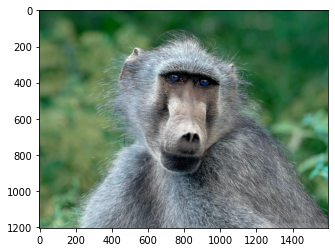

In [28]:
image_arr = np.asarray(image)
plt.imshow(image_arr)

# Generating an adversarial image

In [12]:
import tensorflow as tf

In [13]:
def clip_eps(tensor, eps):
	return tf.clip_by_value(tensor, clip_value_min=-eps, clip_value_max=eps)

Given a tensor `t`, this operation returns a tensor of the same type and shape as `t` with its values clipped to `clip_value_min` and `clip_value_max`. Any values less than `clip_value_min` are set to `clip_value_min`. Any values greater than `clip_value_max` are set to `clip_value_max`. <br>
`eps` refers to epsilon, an infinitesimal number.

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.1)
sccLoss = tf.keras.losses.SparseCategoricalCrossentropy()
EPS = 2 / 255.0

def generate_adversaries(model, baseImage, delta, classIdx, steps=50):

  for step in range(0, steps):
		with tf.GradientTape() as tape:
			tape.watch(delta) # track updates for the variable `delta`

			adversary = preprocess_input(baseImage + delta) # add perturbation

			predictions = model(adversary, training=False) # objectie is to change prediction dramatically
			loss = -sccLoss(tf.convert_to_tensor([classIdx]), predictions) # loss w.r.t. baseImage's class
      
      # in gradient ascent, gradients are used to maximize loss function
      # observe the climb:
			if step % 5 == 0:
				print("step: {}, loss: {}...".format(step,
					loss.numpy()))

		gradients = tape.gradient(loss, delta) # gradient w.r.t. perturbation vector that we want to optimize

		# update the weights, clip the perturbation vector, and
		# update its value
		optimizer.apply_gradients([(gradients, delta)])
		delta.assign_add(clip_eps(delta, eps=EPS)) 

	return delta

In [15]:
baseImage = tf.constant(preprocessedImage, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)

# generate the perturbation vector to create an adversarial example
deltaUpdated = generate_adversaries(model, baseImage, delta, 372)

step: 0, loss: -0.002721774624660611...
step: 5, loss: -0.05188057944178581...
step: 10, loss: -1.3095788955688477...
step: 15, loss: -4.795719146728516...
step: 20, loss: -9.205403327941895...
step: 25, loss: -14.006308555603027...
step: 30, loss: -18.976137161254883...
step: 35, loss: -23.67923355102539...
step: 40, loss: -28.407878875732422...
step: 45, loss: -33.08572006225586...


In [16]:
preprocessedAdv = preprocess_input(baseImage + deltaUpdated)
predictions_adv = model.predict(preprocessedAdv)
predictions_adv = decode_predictions(predictions_adv, top=3)[0]

In [17]:
predictions_adv

[('n02487347', 'macaque', 0.9999999),
 ('n02484975', 'guenon', 7.985328e-08),
 ('n02488291', 'langur', 2.9183594e-08)]

Image recognition algorithm is fooled to recognize a baboon (which it was confident 99%) as a macaque with 99% confidence. Even though these two animals resemble each other quite a lot, confidence levels present the existence of a serious adversarial attack.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


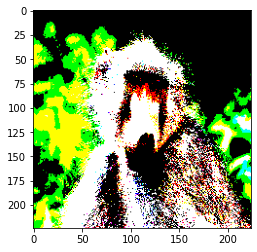

In [30]:
import matplotlib.pyplot as plt
adv = baseImage + deltaUpdated
plt.imshow(np.squeeze(adv))